# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)

First I'm going to train a linear regression model to see how it performs and which features it finds important to predicting cost efficiency.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(y_train)

x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.8)

ols = LinearRegression()
ols.fit(x_tr, y_tr)
ols.score(x_tr, y_tr)

1.0

In [5]:
from sklearn.metrics import mean_squared_error

y_pred = ols.predict(x_te)
mean_squared_error(y_te, y_pred)

4.738713521202259e-22

In [6]:
ols.coef_

array([[-2.55501946e-14,  6.38378239e-16, -1.22124533e-15,
        -2.18437768e-12, -6.87672141e-13,  4.26999365e-13,
        -1.07434596e-13, -2.88550759e-13, -1.16466363e-12,
        -6.32685754e-16, -1.27266429e-14, -1.31757669e-16,
        -1.27812100e-12,  1.52096198e-12, -6.23935889e-14,
        -7.88407976e-15,  2.09831991e-11, -2.76145277e-14,
         8.80311092e-13,  7.24476041e-13,  1.35171844e-12,
         7.07289177e-13, -1.12831600e-13,  1.57071486e-14,
        -7.09354200e-14, -6.72728474e-15,  1.00000000e+00,
         7.78543998e-14,  5.92658450e-14, -4.63587705e-14,
         3.24902780e-14, -3.81560129e-14, -2.53482957e-14,
         1.48815642e-15, -1.05830177e-14,  1.38805572e-14,
        -7.78537723e-15,  8.47424990e-15, -1.10099545e-14,
        -2.59116429e-14, -2.10324091e-14,  2.86207351e-15,
        -1.01417456e-14,  1.35112699e-14, -5.23572241e-20,
         8.47032947e-22,  4.15958958e-14,  4.60296525e-14,
        -1.45427055e-13,  4.43059070e-14,  1.84108879e-1

Great! Perfect R-squared on both the train and test sets, time to pack it up and call it a capstone!

Just kidding, there are way too many coefficients here and it's probably overfit. Let's take a look at Ridge and Lasso regressions to see if they can improve upon this OLS. I'm going to use a randomized search with cross validation to identify alpha

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [19]:
parameters = {'alpha': sp_randFloat(10000000,10000000000)}
ridge = Ridge()
ridge_reg = RandomizedSearchCV(ridge, parameters, n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 75338563.41631173}

In [20]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.108957,0.007775,0.016324,0.000578,4026814658.783855,{'alpha': 4026814658.783855},0.996632,0.995982,0.996867,0.996357,0.996769,0.996521,0.000320,24
1,0.116771,0.000646,0.016678,0.000737,7177318192.272618,{'alpha': 7177318192.272618},0.990344,0.988459,0.990940,0.989534,0.990649,0.989985,0.000896,46
2,0.114852,0.004397,0.015023,0.002175,6511794543.47162,{'alpha': 6511794543.47162},0.991882,0.990300,0.992395,0.991204,0.992153,0.991587,0.000757,38
3,0.115577,0.007973,0.016944,0.000575,3743088280.124309,{'alpha': 3743088280.124309},0.997062,0.996495,0.997269,0.996822,0.997184,0.996966,0.000280,20
4,0.114492,0.003833,0.013800,0.006934,1095979182.385983,{'alpha': 1095979182.3859832},0.999724,0.999671,0.999746,0.999702,0.999737,0.999716,0.000027,4


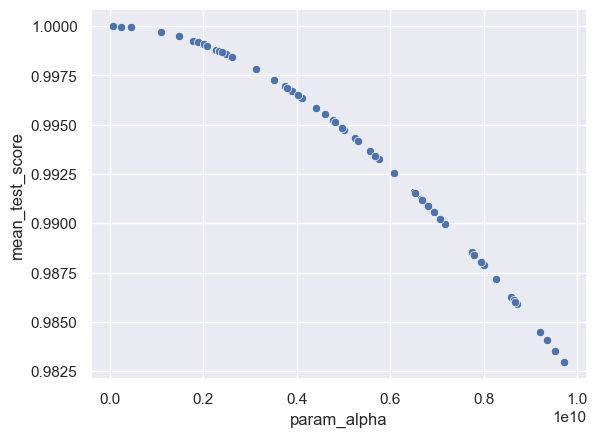

In [21]:
sns.scatterplot(data=random_ridge_results, x='param_alpha', y='mean_test_score')
plt.show()

In [10]:
parameters = {'alpha': sp_randInt(10000,10000000)}
lasso = linear_model.Lasso()
rand = RandomizedSearchCV(lasso, parameters, n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

{'alpha': 30737}

In [11]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)
rand_lasso_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.125523,0.004228,0.023802,0.006524,8335804,{'alpha': 8335804},0.052581,0.051972,0.054364,0.047280,0.052663,0.051772,0.002383,51
1,0.134431,0.010250,0.014536,0.002724,1494405,{'alpha': 1494405},0.690161,0.649225,0.705634,0.660492,0.704175,0.681937,0.023038,9
2,0.130042,0.009697,0.012469,0.006039,2225104,{'alpha': 2225104},0.313093,0.222338,0.347397,0.247318,0.344159,0.294861,0.051074,13
3,0.128186,0.010194,0.016053,0.000493,5167699,{'alpha': 5167699},0.092952,0.066405,0.089073,0.083407,0.074527,0.081273,0.009679,38
4,0.135463,0.009196,0.017779,0.002241,8232403,{'alpha': 8232403},0.054083,0.052955,0.055629,0.048655,0.053592,0.052983,0.002337,50


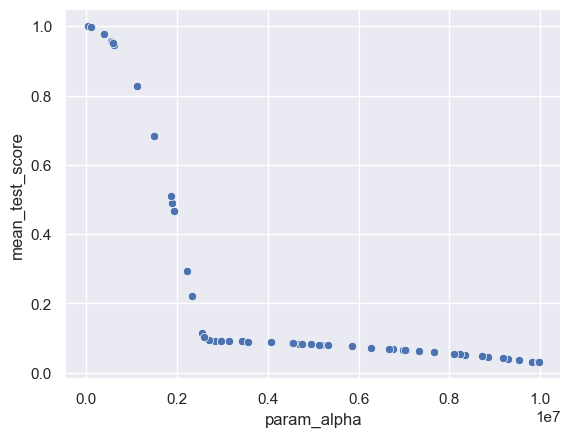

In [12]:
sns.scatterplot(data=rand_lasso_params, x='param_alpha', y='mean_test_score')
plt.show()